# House Rocket Sales 

## 0.0 IMPORTS


In [1]:
import pandas as pd
import numpy as np
import time
from multiprocessing import Pool
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from matplotlib import pyplot as plt
from matplotlib import gridspec
from IPython.core.display import HTML
from geopy.geocoders import Nominatim
from IPython.core.display import HTML
import seaborn as sns
import warnings
import plotly.express as px
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## 0.1 Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


C:\Users\fabic\Anaconda3\envs\houserocketsales\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['interactive']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2 Loading Data

In [4]:
data = pd.read_csv('data/kc_house_data.csv')

# 1.0 DATA DESCRIPTION

In [5]:
df1 = data.copy()

## 1.1 Data Types and Dimensions

In [6]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 21613
Number of columns: 21


In [7]:
df1.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

## 1.2 Check NA

In [8]:
df1.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

## 1.3 Change Data Types

In [9]:
# id, yr_built, yr_renovated, zipcode
df1[['id', 'waterfront', 'view', 'condition', 'yr_built', 'yr_renovated', 'zipcode']] = df1[['id', 'waterfront', 'view', 'condition', 'yr_built', 'yr_renovated', 'zipcode']].astype(str)

# lat, long
df1[['lat', 'long']] = df1[['lat', 'long']].astype(str)

# Date
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

id                       object
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront               object
view                     object
condition                object
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built                 object
yr_renovated             object
zipcode                  object
lat                      object
long                     object
sqft_living15             int64
sqft_lot15                int64
dtype: object

## 1.4 Descriptive Statistics

In [10]:
# numerical attributes
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

# categorical attributes
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.4.1 Numerical Attributes

In [11]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,price,75000.00,7700000.00,7625000.00,540088.14,450000.00,367118.70,4.02,34.59
1,bedrooms,0.00,33.00,33.00,3.37,3.00,0.93,1.97,49.06
2,bathrooms,0.00,8.00,8.00,2.11,2.25,0.77,0.51,1.28
3,sqft_living,290.00,13540.00,13250.00,2079.90,1910.00,918.42,1.47,5.24
4,sqft_lot,520.00,1651359.00,1650839.00,15106.97,7618.00,41419.55,13.06,285.08
5,floors,1.00,3.50,2.50,1.49,1.50,0.54,0.62,-0.48
6,grade,1.00,13.00,12.00,7.66,7.00,1.18,0.77,1.19
7,sqft_above,290.00,9410.00,9120.00,1788.39,1560.00,828.07,1.45,3.40
8,sqft_basement,0.00,4820.00,4820.00,291.51,0.00,442.56,1.58,2.72
9,sqft_living15,399.00,6210.00,5811.00,1986.55,1840.00,685.38,1.11,1.60


### 1.4.2 Categorical Attributes

In [12]:
cat_attributes.apply(lambda x: x.unique().shape[0])

id              21436
waterfront          2
view                5
condition           5
yr_built          116
yr_renovated       70
zipcode            70
lat              5034
long              752
dtype: int64

<AxesSubplot:xlabel='condition', ylabel='count'>

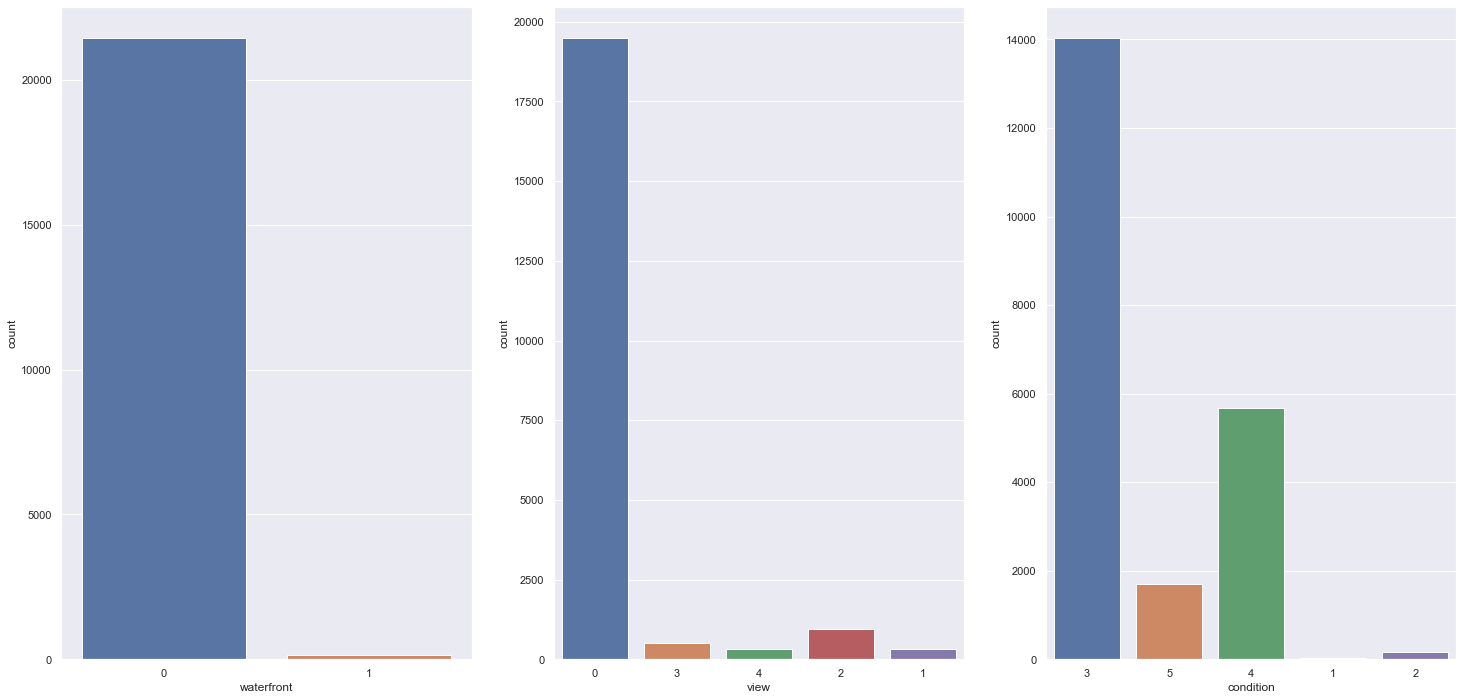

In [13]:
plt.subplot(1, 3, 1)
sns.countplot(df1['waterfront'])

plt.subplot(1, 3, 2)
sns.countplot(df1['view'])

plt.subplot(1, 3, 3)
sns.countplot(df1['condition'])

# 2.0 FEATURE ENGINEERING

In [14]:
df2 = df1.copy()

In [15]:
# Search for duplicates
print('Number of rows: {}'.format(df2.shape[0]))
print('Number of IDs: {}'.format(len(df2['id'].unique())))

Number of rows: 21613
Number of IDs: 21436


In [16]:
# Drop duplicate ID's
df2 = df2.drop_duplicates(subset = ['id'], keep = 'last')

In [17]:
# Drop NA
df2 = df2.dropna()
df2 = df2.reset_index(drop=True)

In [18]:
# Watching for outliers

unique = df2[['bedrooms','bathrooms','floors','waterfront','view','condition','grade']]

for i in unique:
    print('Attribute: {} - {}'.format(i, df2[i].unique().tolist()))

Attribute: bedrooms - [3, 2, 4, 5, 1, 6, 7, 0, 8, 9, 11, 10, 33]
Attribute: bathrooms - [1.0, 2.25, 3.0, 2.0, 4.5, 1.5, 2.5, 1.75, 2.75, 3.25, 4.0, 3.5, 0.75, 4.75, 5.0, 4.25, 3.75, 0.0, 1.25, 5.25, 6.0, 0.5, 5.5, 6.75, 5.75, 8.0, 7.5, 7.75, 6.25, 6.5]
Attribute: floors - [1.0, 2.0, 1.5, 3.0, 2.5, 3.5]
Attribute: waterfront - ['0', '1']
Attribute: view - ['0', '3', '4', '2', '1']
Attribute: condition - ['3', '5', '4', '1', '2']
Attribute: grade - [7, 6, 8, 11, 9, 5, 10, 12, 4, 3, 13, 1]


In [19]:
# Removing outlier from 'bedrooms' column
df2.drop(df2.loc[df2['bedrooms'] == 33].index, inplace = True)

## Creating new features

In [20]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year-week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# house age
df2['house_age'] = 'NA'
df2.loc[df2['date'] > '2014-01-01', 'house_age'] = 'new_house'
df2.loc[df2['date'] < '2014-01-01', 'house_age'] = 'old_house'

# condition type
df2['condition'] = df2['condition'].astype(int64)
df2['condition_type'] = df2['condition'].apply(lambda x: 'bad' if x<=2 else 'regular' if (x==3)| (x==4) else 'good')

# Basement
df2['basement'] = df2['sqft_basement'].apply(lambda x: 'no' if x == 0 else 'yes')        

# Season
df2['season'] = df2['month'].apply(lambda x: 'summer' if (x > 5) & (x < 8)  else
                                             'spring' if (x > 2) & (x < 5)  else
                                             'fall'   if (x > 8) & (x < 12) else
                                             'winter')
# Renovated
df2['renovated'] = df2['yr_renovated'].apply(lambda x: 'no' if x == 0 else 'yes')

# Year of Construction
df2['yr_built'] = df2['yr_built'].astype(int64)
df2['construction'] = df2['yr_built'].apply(lambda x: '<1955' if x <= 1955 else '>1955')

# Describe condition
df2['describe_condition'] = df2['condition'].apply(lambda x: 'too bad' if x == 1 else
                                                             'bad'     if x == 2 else
                                                             'median'  if x == 3 else
                                                             'good'    if x == 4 else
                                                             'excellent')

In [21]:
# Describe price level
df2['price_level'] = 'NA'  
for i in range(len(df2)):
    if (df2.iloc[i, 2] > 0) & (df2.iloc[i, 2] < 321950):
        df2.loc[i, 'price_level'] = 0
    elif (df2.iloc[i, 2] >= 321950) & (df2.iloc[i, 2] < 450000):
        df2.loc[i, 'price_level'] = 1
    elif (df2.iloc[i, 2] >= 450000) & (df2.iloc[i, 2] < 645000):
        df2.loc[i, 'price_level'] = 2
    else:
        df2.loc[i, 'price_level'] = 3

In [22]:
# Describe standard (price < 540,000) and high standard (price > 540,000)
df2['standard'] = 'standard'  
for i in range(len(df2)):
    if (df2.iloc[i, 2] > 540000):
        df2.loc[i, 'standard'] = 'high_standard'

### Using API geolocator, add the following features to dataset:
- Place ID: property location identification
- OSM Type: Open Street Map type
- County: name of the county
- Postal Code: postal code of the property

In [23]:
df2['query'] = df2[['lat', 'long']].apply(lambda x: str(x['lat']) + ',' + str(x['long']), axis=1)

In [24]:
# As Jupyter Notebook doesn't run multi-thread parallelism processes, this function is saved in a separate file 
# and has been imported as a module in the next snippet. 

# def get_data(x):
#     index, row = x
#     time.sleep(1)
    
#     # API call
#     response = geolocator.reverse(row['query'])
    
#     place_id = response.raw['place_id']
#     osm_type = response.raw['osm_type']
#     county = response.raw['address']['county']
#     postal_code = response.raw['address']['postcode']
        
#     return place_id, osm_type, county, postal_code

In [25]:
# import defs

# df_api = df2[['id', 'query']].head(5).copy()

# p = Pool(3)

# start = time.process_time()
# df_api[['place_id', 'osm_type', 'county', 'postal_code']] = p.map(defs.get_data, df_api.iterrows())
# end = time.process_time()

# print('Time elapsed: {}'.format(end - start))

In [26]:
# df_api.head(10).T

# 3.0 EDA - Exploratory Data Analysis

In [27]:
df3 = df2.copy()

## 3.1 Hipothesis & Insights

### H1: Properties with water view would be more expensive

<AxesSubplot:xlabel='waterfront', ylabel='price'>

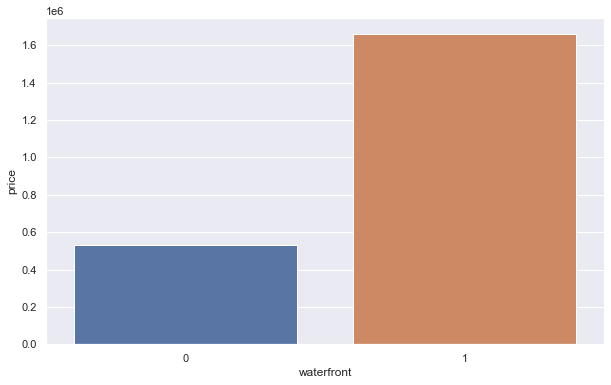

In [28]:
h1 = df3[['price','waterfront']].groupby('waterfront').mean().reset_index()
plt.figure(figsize=(10,6))
sns.barplot(h1['waterfront'],h1['price'])

In [29]:
h1_percent = (h1.loc[1,'price'] - h1.loc[0,'price']) / h1.loc[0,'price']
print('H1 is True: properties with waterview are in the mean {0:.0%} more expensive'.format(h1_percent))

H1 is True: properties with waterview are in the mean 212% more expensive


### H2: Properties constructed before 1955 would be less expensive

<AxesSubplot:xlabel='construction', ylabel='price'>

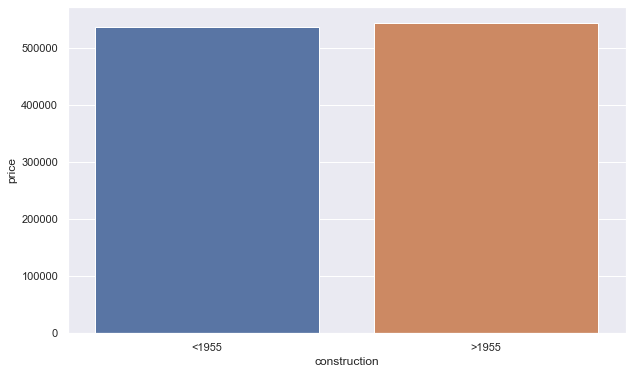

In [30]:
h2 = df3[['price','construction']].groupby('construction').mean().reset_index()
plt.figure(figsize=(10,6))
sns.barplot(h2['construction'],h2['price'])

In [31]:
h2_percent = (h2.loc[1,'price'] - h2.loc[0,'price']) / h2.loc[1,'price']
print('H2 is False: properties constructed before 1955 are in the mean only {0:.0%} less expensive'.format(h2_percent))

H2 is False: properties constructed before 1955 are in the mean only 1% less expensive


### H3: Properties without basement would have larger square footage

<AxesSubplot:xlabel='basement', ylabel='sqft_lot'>

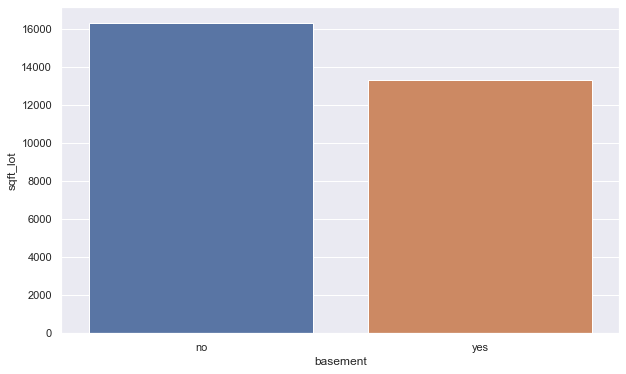

In [32]:
h3 = df3[['sqft_lot','basement']].groupby('basement').mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(h3['basement'],h3['sqft_lot'])

In [33]:
h3_percent = (h3.loc[0,'sqft_lot'] - h3.loc[1,'sqft_lot']) / h3.loc[1,'sqft_lot']
print('H3 is True: properties with no basement have square footage {0:.0%} larger'.format(h3_percent))

H3 is True: properties with no basement have square footage 23% larger


### H4: Prices would have rised up YoY (Year over Year)

<AxesSubplot:xlabel='year', ylabel='price'>

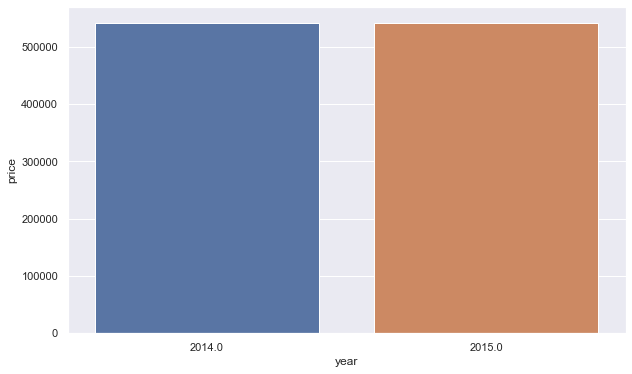

In [34]:
h4 = df3[['price','year']].groupby('year').mean().reset_index()
plt.figure(figsize=(10,6))
sns.barplot(h4['year'],h4['price'])

In [35]:
h4_percent = (h4.loc[1,'price'] - h4.loc[0,'price']) / h4.loc[0,'price']
print('H4 is False: price growth from 2014 to 2015 was {0:.0%}'.format(h4_percent))

H4 is False: price growth from 2014 to 2015 was 0%


### H5: Properties with more bedrooms would be more expensive

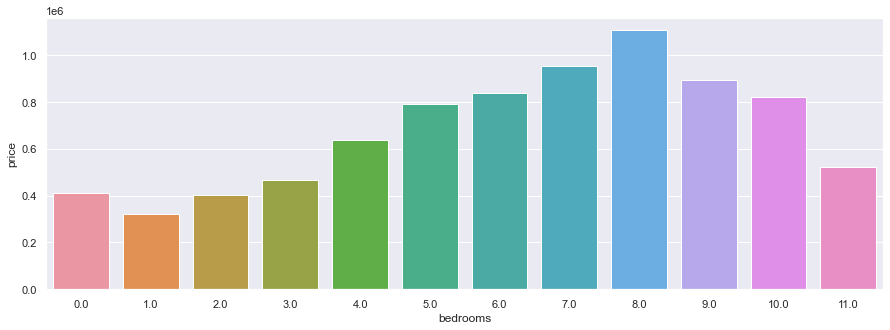

In [36]:
h5 = df3[['price','bedrooms']].groupby('bedrooms').mean().reset_index()

plt.figure(figsize=(15,5))
sns.barplot(h5['bedrooms'],h5['price'])

median = h5['bedrooms'].median()

bed_above = h5['price'][h5['bedrooms'] > median].mean()
bed_below = h5['price'][h5['bedrooms'] < median].mean()

In [37]:
h5_percent = (bed_above - bed_below) / bed_below
print('H5 is True: properties with more than 5 beds are {0:.0%} more expensive.'.format(h5_percent))

H5 is True: properties with more than 5 beds are 69% more expensive.


# 4.0 BUSINESS QUESTIONS & SOLUTIONS

In [49]:
df4 = df3.copy()

In [50]:
df4.sample(5).T

,16239,20012,6479,13798,628
id,5101402618,1112630130,1240700006,2739200040,8832900550
date,2014-08-20 00:00:00,2015-02-20 00:00:00,2015-05-11 00:00:00,2014-09-24 00:00:00,2014-09-12 00:00:00
price,935000.00,429900.00,870000.00,302000.00,650000.00
bedrooms,4.00,4.00,3.00,5.00,3.00
bathrooms,3.00,3.25,2.00,2.00,2.50
sqft_living,3680.00,2880.00,2320.00,1540.00,2690.00
sqft_lot,7105.00,5929.00,65340.00,9629.00,11575.00
floors,2.00,2.50,1.50,1.00,1.00
waterfront,0,0,0,0,0
view,2,0,0,0,3


## 4.1 Map showing where the houses are geographically located

In [51]:
df4['lat'] = df4['lat'].astype(float64)
df4['long'] = df4['long'].astype(float64)

In [52]:
df4['price'].fillna(0, inplace=True)

In [53]:
df4['waterfront'] = df4['waterfront'].apply(lambda x: "yes" if x=="1" else "no")

In [54]:
# Interactive buttons - widgets to control data

style = {'description_width': 'initial'}

# filter by waterfront
waterfront_bar = widgets.Dropdown(
    options=df4['waterfront'].unique().tolist(),
    value='no',
    description='Water View',
    disable=False)

# limit by price
price_limit = widgets.IntSlider(
    value=int(df4['price'].mean()),
    min=int(df4['price'].min()),
    max=int(df4['price'].max()),
    step=1,
    description='Maximum Price',
    disable=False,
    style={'description_width': 'initial'})

# limit living room squarefootage
livingroom_limit = widgets.IntSlider(
    value=int(df4['sqft_living'].mean()),
    min=df4['sqft_living'].min(),
    max=df4['sqft_living'].max(),
    step=1,
    description='Minimum Living Room Size',
    disable=False,
    style={'description_width': 'initial'})

# limit by bathrooms
bathroom_limit = widgets.IntSlider(
    value=df4['bathrooms'].min(),
    min=df4['bathrooms'].min(),
    max=df4['bathrooms'].max(),
    step=1,
    description='Minimum Number of Bathrooms',
    disable=False,
    style={'description_width': 'initial'})

# limit basement squarefootage
basement_limit = widgets.IntSlider(
    value=int(df4['sqft_basement'].mean()),
    min=df4['sqft_basement'].min(),
    max=df4['sqft_basement'].max(),
    step=1,
    description='Maximum Basement Size',
    disable=False,
    style={'description_width': 'initial'})

# limit property condition
condition_limit = widgets.IntSlider(
    value=df4['condition'].min(),
    min=df4['condition'].min(),
    max=df4['condition'].max(),
    step=1,
    description='Property Minimum Condition',
    disable=False,
    style={'description_width': 'initial'})

# limit construction year
construction_limit = widgets.IntSlider(
    value=int(df4['yr_built'].mean()),
    min=df4['yr_built'].min(),
    max=df4['yr_built'].max(),
    step=1,
    description='Year of Construction from',
    disable=False,
    style={'description_width': 'initial'})

In [55]:
def update_map (df4, waterfront, limit, livingroom_limit, bathroom_limit, basement_limit, condition_limit, construction_limit):
    
    houses = df4[(df4['waterfront'] == waterfront) &
                 (df4['price'] <= limit) & 
                 (df4['sqft_living'] >= livingroom_limit) &
                 (df4['bathrooms'] >= bathroom_limit) &
                 (df4['sqft_basement'] <= basement_limit) &
                 (df4['condition'] >= condition_limit) &
                 (df4['yr_built'] >= construction_limit)
                ][['id', 'lat', 'long', 'price', 'price_level', 'sqft_living', 'bathrooms', 'sqft_basement', 'condition', 'yr_built']].copy()
    
    fig = px.scatter_mapbox(houses, lat='lat', lon='long', color='price_level', size='price', 
                         color_continuous_scale=px.colors.named_colorscales(),
                         size_max=15,
                         zoom=10)
    fig.update_layout(mapbox_style='open-street-map')
    fig.update_layout(height=600, margin={'r':0, 't':0, 'l':0, 'b':0})
    fig.show()

In [56]:
widgets.interactive(update_map, df4=fixed(df4), 
                    waterfront=waterfront_bar, limit=price_limit, livingroom_limit=livingroom_limit, 
                    bathroom_limit=bathroom_limit, basement_limit=basement_limit, condition_limit=condition_limit, 
                    construction_limit=construction_limit)

# USE KEYBOARD "+" AND "-" TO ZOOM IN/OUT THE MAP
# EACH POINT INDICATES A PROPERTY AND ITS FEATURES

interactive(children=(Dropdown(description='Water View', options=('no', 'yes'), value='no'), IntSlider(value=5…

## 4.2 Dashboard with interactive charts

In [58]:
df4 = df4.dropna(axis=0)

In [63]:
# change date format
df4.loc[:, 'year'] = pd.to_datetime(df4.loc[:, 'date']).dt.strftime('%Y')
df4.loc[:, 'date'] = pd.to_datetime(df4.loc[:, 'date']).dt.strftime('%Y-%m-%d')
df4.loc[:, 'year_week'] = pd.to_datetime(df4.loc[:, 'date']).dt.strftime('%Y-%U')

In [64]:
df4['year'].min()

'2014'

In [67]:
df4.loc[:, 'id'] = df4.loc[:, 'id'].astype(int64)
df4.loc[:, 'yr_built'] = df4.loc[:, 'yr_built'].astype(int64)

In [82]:
# Interactive buttons - widgets to control data

# filter by waterfront
waterfront_box = widgets.Checkbox(
    value=False,
    options=df4.loc[:, 'waterfront'].unique().tolist(),
    description='Water View',
    disable=False)

# property availability
date_limit = widgets.SelectionSlider(
    options=df4.loc[:, 'date'].sort_values().unique().tolist(),
    value = '2014-12-01',
    description = "Availability from",
    style={'description_width':'initial'},
    disable=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True )

# renovation year
renovation_limit = widgets.SelectionSlider(
    options=df4.loc[:, 'yr_renovated'].sort_values().unique().tolist(),
    value = '2000',
    description = "Renovation Year from",
    style={'description_width':'initial'},
    disable=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True )

In [86]:
def update_dashboard( df4, waterfront_box, date_limit, renovation_limit):
    
    # Filtering data
    df = df4[(df4['date'] > date_limit) &
             (df4['yr_renovated'] > renovation_limit) &
             (df4['waterfront'] == waterfront_box)].copy()
    
    fig = plt.figure(figsize=(24, 12))
    
    specs = gridspec.GridSpec( ncols=2, nrows=2, figure=fig )
    
    ax1 = fig.add_subplot( specs[0, :] ) # First row
    ax2 = fig.add_subplot( specs[1, 0] ) # Second Row First Column
    ax3 = fig.add_subplot( specs[1, 1] ) # Second Row Second Column  rows
    
    # first graph
    by_year = df[['id', 'year']].groupby( 'year').sum().reset_index()
    sns.barplot(x='year', y='id', data=by_year, ax=ax1)
    
    # second graph
    by_day = df[['id', 'date']].groupby('date').mean().reset_index()
    sns.lineplot(x='date', y='id', data=by_day, ax=ax2)
    plt.xticks( rotation=90 );
    
    # third graph
    by_week_of_year = df[['id', 'year_week']].groupby('year_week').mean().reset_index()
    sns.barplot(x='year_week', y='id', data=by_week_of_year, ax=ax3)
    plt.xticks( rotation=90 );

interactive(children=(Checkbox(value=False, description='Water View'), SelectionSlider(continuous_update=False…

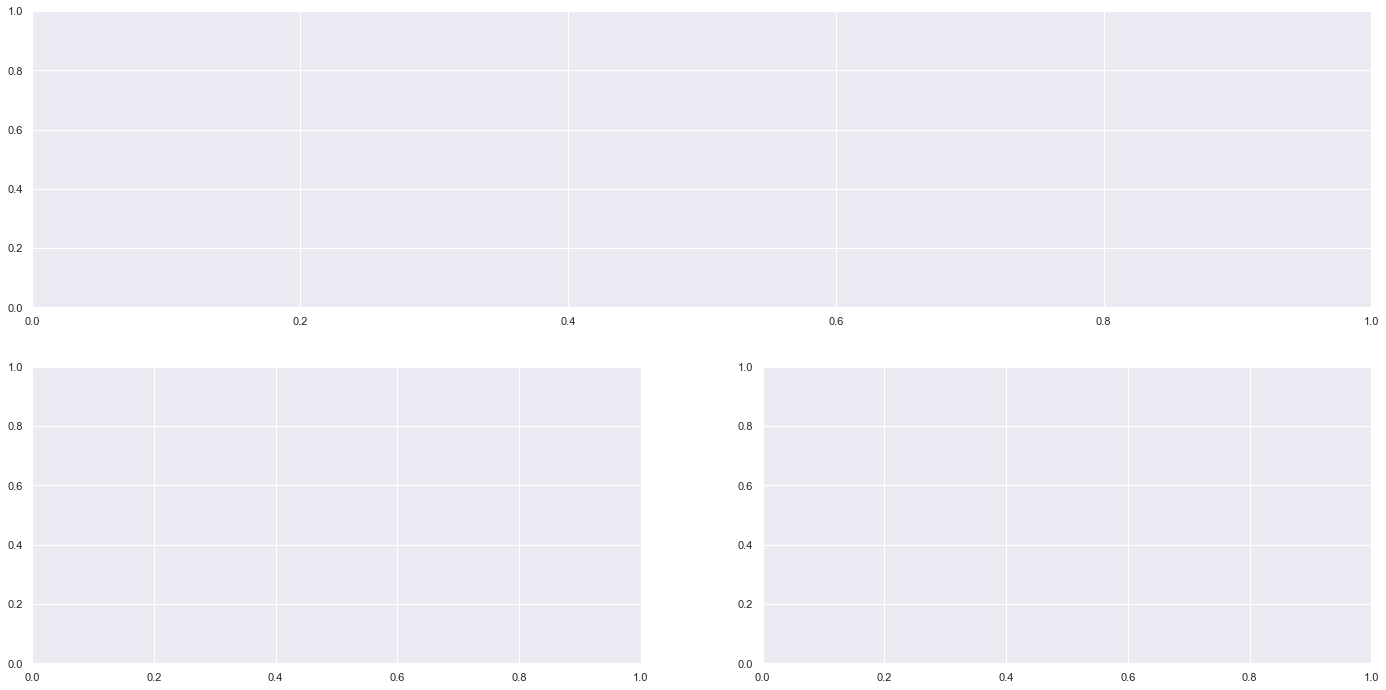

In [87]:
widgets.interactive(update_dashboard, df4=fixed(df4), 
                    date_limit=date_limit, 
                    renovation_limit=renovation_limit, 
                    waterfront_box=waterfront_box)

## 4.1 Which properties should be bought by House Rocket and at what price?

In [ ]:
# Group by zipcode and calculate median of price

df4 = df4[['zipcode','price']].groupby('zipcode').median().reset_index()
df4 = df4.rename(columns={'price': 'price_median'})

# unir o df2 com o dataset original, alocando cada preço mediano em cada linha, através do zipcode

df = pd.merge(df1,df,on='zipcode',how='inner')

# pra cada imóvel, colocar na coluna "status" os indicadores "buy" ou "no buy" de dependendo das condições:

# a) o preço for menor que a mediana da região;
# b) o imóvel estiver em boas condições

for i in range(len(df)):
    
    if (df.loc[i,'price'] < df.loc[i,'price_median']) & (df.loc[i,'condition'] >= 3):
        df.loc[i,'status'] = 'buy'
    
    else:
        df.loc[i,'status'] = 'no buy'

In [ ]:
# criar relatório com apenas as colunas de interesse, ordenando do menor preço para o maior, considerando as melhores condições de imóveis 
buy_houses = df[df['status'] == 'buy'].sort_values(by=['describe_condition','price'])
buy_houses[['id','zipcode','price','price_median','condition']].head()

print('Foram encontrados {} imóveis dentro das condições acima, sugeridos para compra'.format(len(buy_houses)))

### 4.2) Uma vez a casa comprada, qual o melhor momento para vendê-las e por qual preço ?

In [ ]:
# Agrupar os imóveis por região ( coluna zipcode ) e por sazonalidade(season)
# Dentro de cada região/season encontrar a mediana do preço do imóvel.

df2 = df[['zipcode','season','price']].groupby(['zipcode','season']).median().reset_index()
df2 = df2.rename(columns={'price': 'price_median_season'})


# unir df2 com df
df3 = pd.merge(buy_houses,df2,how ='inner', on=['zipcode','season'])


In [ ]:
# Condições de venda:
# 1. Se o preço da compra for maior que a mediana da região + sazonalidade.
# O preço da venda será igual ao preço da compra + 10%
# 2. Se o preço da compra for menor que a mediana da região + sazonalidade.
# O preço da venda será igual ao preço da compra + 30%
        
for i in range(len(df3)):
            if df3.loc[i, 'price'] <= df3.loc[i, 'price_median_season']:
                 df3.loc[i, 'sale_price'] = df3.loc[i, 'price'] * 1.30
            elif df3.loc[i, 'price'] > df3.loc[i, 'price_median_season']:
                 df3.loc[i, 'sale_price'] = df3.loc[i, 'price'] * 1.10
            else:
                 pass
                
df3['profit'] = df3['sale_price'] - df3['price']

In [ ]:
# relatório final: Sugestões de compra, com possíveis indicadores de preço de venda e lucro
df3[['id','zipcode','price','price_median','season','price_median_season','describe_condition','sale_price','profit']].head()

In [ ]:
# Total do lucro considerando quadro de sugestão
df3['profit'].sum()

In [ ]:
# Custo total
df3['price'].sum()

In [ ]:
# Receita total
df3['sale_price'].sum()

### 4.3) Insights - Imóveis selecionados

In [ ]:
# Seleção dos atributos cujo array é analisável
df4 = df3[['zipcode','bedrooms','bathrooms','floors','season',
           'renovated','describe_condition','waterfront_','basement','grade','view','constrution']]

In [ ]:
print("Insights - Imóveis selecionados")
conditions = []
for i in df4.columns:
            ins = df3[['profit',i]].groupby(i).sum().reset_index()
            plt.figure(figsize=(20,12))
            sns.barplot(ins[i],ins['profit']).set(title='Profit x {}'.format(i))
            plt.xticks(rotation=60);
            ins2 = ins[ins['profit'] == ins['profit'].max()]
            conditions.append(ins2.iloc[0,0])
            print('Imóveis mais lucrativos são os com "{}" igual a "{}"'.format(i, ins2.iloc[0,0]))


In [ ]:
dx = pd.DataFrame(columns=['atributo','condicao','total_imoveis','%_imoveis','lucro_total','%_lucro'])

dx['atributo'] = ['zipcode','bedrooms','bathrooms','floors','season',
           'renovated','describe_condition','waterfront_','basement','grade','view','constrution']

dx['condicao'] = conditions

for i in range(len(dx)):
    dx.loc[i,'total_imoveis'] = df3['id'][df3[dx.loc[i,'atributo']] == dx.loc[i,'condicao']].count()
    dx.loc[i,'%_imoveis'] = float(dx.loc[i,'total_imoveis'] / df3['id'].count() * 100)
    dx.loc[i,'lucro_total'] = df3['profit'][df3[dx.loc[i,'atributo']] == dx.loc[i,'condicao']].sum()
    dx.loc[i,'%_lucro'] = float(dx.loc[i,'lucro_total'] / df3['profit'].sum() * 100)

dx

#### 4.3.1) Teste de Pareto

In [ ]:
cond = [df3[df3['zipcode']== 98052],
         df3[df3['bedrooms']== 3],
        df3[df3['bathrooms']== 1.0],
        df3[df3['floors']== 1.0],
        df3[df3['season']== 'winter'],
        df3[df3['renovated']== 'no'],
        df3[df3['describe_condition'] == 'median'],
        df3[df3['waterfront_']== 'não'],
        df3[df3['basement']== 'no'],
        df3[df3['grade']== 7],
        df3[df3['view']== 0],
        df3[df3['constrution']== '> 1955']]


In [ ]:
for i in cond:
    pareto = i
    par = pareto['profit'].sum() / df3['profit'].sum()
    count = pareto['id'].count() / df3['id'].count()
    print('O número de imóveis na condição é de {} % do total de imóveis'.format(count * 100))
    print('O percentual do lucro corresponde a {} %\n'.format(par * 100))
